# Pràctica 1: Identificació d'Idioma
**Assignatura:** Processament del Llenguatge Humà (PLH)  
**Model:** Model de llenguatge basat en n-grames de caràcters 

## 1. Introducció
L'objectiu d'aquesta pràctica és construir un classificador automàtic capaç d'assignar un idioma $l_i$ a un document $d$ d'entre un conjunt de 6 llengües europees: alemany (deu), anglès (eng), francès (fra), italià (ita), neerlandès (nld) i castellà (spa).

El sistema es basa en la hipòtesi que les freqüències de certes seqüències de lletres (n-grames) són úniques per a cada idioma. En aquest cas, utilitzarem **trigrammes de caràcters** (n=3).

### Recursos
**Entrenament (Training):** 30.000 frases per idioma del corpus Wortschatz Leipzig.

**Validació (Test):** 10.000 frases per idioma per avaluar la precisió (accuracy) i generar la matriu de confusió.



In [6]:
import re
import os
import math
import pandas as pd
import nltk
from nltk.collocations import TrigramCollocationFinder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Pas 1: Preprocessament del Text
El text brut ha de ser normalitzat abans de l'entrenament per evitar biaixos causats per elements no lingüístics. 

### Procediment de neteja:
1. **Eliminar els dígits**: S'eliminen els números del text, ja que no són informatius per identificar l'idioma.
2. **Convertir a minúscula**: Es normalitzen tots els caràcters per reduir la dispersió de dades.
3. **Substitució d'espais**: Es canvien els espais en blanc continus (o tabulacions) per un sol espai.
4. **Unió de frases**: Es concatenen totes les frases del corpus inserint un **espai doble** entre elles.

In [5]:
def preprocess_text(frases):
    """
    Neteja del text:
    - Eliminar els dígits del text.
    - Convertir tot el text a minúscules.
    - Substituir els espais en blanc continus per un de sol.
    - Concatenar totes les frases amb un espai doble (també a l'inici i al final).
    """

    neteja = []

    for linia in frases:
        text = re.sub(r'\d+', '', linia) # Eliminar els dígits
        text = text.lower() # Convertir a minúscules 
        text = re.sub(r'\s+', ' ', text).strip() # Deixar un sol espai en blanc
        
        if text:
            neteja.append(text)

    return "  " + "  ".join(neteja) + "  " # Concatenar les frases amb un espai doble

# Llista d'idiomes
idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa'] 

for idioma in idiomes:
    for tipus in ['trn', 'tst']:
        nom_fitxer = f"{idioma}_{tipus}.txt"
        
        if os.path.exists(nom_fitxer):
            print(f"Processant {nom_fitxer}...")
            
            with open(nom_fitxer, 'r', encoding='utf-8') as f:
                # Guardem les línies del fitxer com una llista d'strings
                linies = f.readlines()
            
            text_net = preprocess_text(linies) # Preprocés de cada fitxer
            
            # Guardem el resultat en un fitxer nou
            nom_sortida = f"{idioma}_{tipus}_clean.txt"
            with open(nom_sortida, 'w', encoding='utf-8') as f_out:
                f_out.write(text_net)
                
            print(f"Desat: {nom_sortida}")

Processant deu_trn.txt...
Desat: deu_trn_clean.txt
Processant deu_tst.txt...
Desat: deu_tst_clean.txt
Processant eng_trn.txt...
Desat: eng_trn_clean.txt
Processant eng_tst.txt...
Desat: eng_tst_clean.txt
Processant fra_trn.txt...
Desat: fra_trn_clean.txt
Processant fra_tst.txt...
Desat: fra_tst_clean.txt
Processant ita_trn.txt...
Desat: ita_trn_clean.txt
Processant ita_tst.txt...
Desat: ita_tst_clean.txt
Processant nld_trn.txt...
Desat: nld_trn_clean.txt
Processant nld_tst.txt...
Desat: nld_tst_clean.txt
Processant spa_trn.txt...
Desat: spa_trn_clean.txt
Processant spa_tst.txt...
Desat: spa_tst_clean.txt


## 3. Pas 2: Generació del Model i Filtratge amb NLTK

Per a la construcció del model de llenguatge basat en caràcters, utilitzarem la llibreria **NLTK**, concretament la classe `TrigramCollocationFinder`.

### Procediment:
1. **Extracció de Trigrammes de caràcters:** Com que volem un model basat en caràcters, passarem l'string sencer (el text prèviament netejat) a la funció `from_words()`. D'aquesta manera, NLTK tractarà cada lletra i espai com una unitat bàsica, generant seqüències de 3 caràcters (ex: `('c', 'a', 's')`).
2. **Filtratge de freqüències:** Per reduir el soroll estadístic i eliminar combinacions rares o errors, eliminem els trigrammes que apareguin menys de 5 vegades al corpus. Utilitzarem la funció nativa d'NLTK `apply_freq_filter(5)`.
3. **Obtenció del diccionari:** Finalment, extreurem les freqüències filtrades mitjançant l'atribut `ngram_fd`, que ens retorna un diccionari de freqüències (FreqDist) llest per ser utilitzat en el càlcul de probabilitats.

In [7]:
# Diccionari global per emmagatzemar la freqüència dels trigrammes de cada idioma
models_entrenament = {}

for idioma in idiomes:
    nom_fitxer_train = f"{idioma}_trn_clean.txt"
    
    # Llegim el fitxer de text netejat d'entrenament
    with open(nom_fitxer_train, 'r', encoding='utf-8') as f:
        text_net = f.read()
    
    # Generem els trigrammes de caràcters utilitzant NLTK
    finder = TrigramCollocationFinder.from_words(text_net)
    
    # Apliquem el filtre per eliminar els trigrammes amb freqüència < 5
    finder.apply_freq_filter(5)
    
    # Guardem la distribució de freqüències al nostre diccionari
    models_entrenament[idioma] = finder.ngram_fd
    
    
    num_trigrames = len(models_entrenament[idioma])
    print(f"Model per '{idioma}' generat amb èxit. Trigrammes únics: {num_trigrames}")

print("\nTots els models d'entrenament han estat generats i emmagatzemats a 'models_entrenament'.")

Model per 'deu' generat amb èxit. Trigrammes únics: 11321
Model per 'eng' generat amb èxit. Trigrammes únics: 9390
Model per 'fra' generat amb èxit. Trigrammes únics: 10421
Model per 'ita' generat amb èxit. Trigrammes únics: 8325
Model per 'nld' generat amb èxit. Trigrammes únics: 10148
Model per 'spa' generat amb èxit. Trigrammes únics: 9294

Tots els models d'entrenament han estat generats i emmagatzemats a 'models_entrenament'.


## 4. Pas 3: Càlcul de Probabilitats i Tècniques de Suavitzat (Smoothing)

Per calcular la probabilitat que un document de text pertanyi a un idioma determinat, utilitzem un model basat en n-grames assumint independència condicional (enfocament *Naive Bayes*). La probabilitat del document sencer s'estima com el producte de les probabilitats individuals de cada trigramma que el compon.

El problema d'utilitzar l'estimació de Màxima Versemblança (MLE) és la dispersió de dades: assigna una probabilitat de zero als trigrammes no observats durant l'entrenament, la qual cosa anul·la automàticament la probabilitat de tota la frase. Per evitar-ho, utilitzarem i compararem **tres tècniques de suavitzat (smoothing)**.

### 4.1. L'espai mostral i l'estimació de $B$

Abans d'aplicar qualsevol fórmula, cal definir acuradament l'espai mostral. Totes les tècniques necessitaran el paràmetre **$B$**, que representa la mida del vocabulari, és a dir, el nombre de trigrammes *potencialment observables*.

**Per què $B$ ha de ser global i igual per a tots els idiomes?**
Si volem comparar de forma justa $P(text | anglès)$ i $P(text | francès)$ mitjançant un `argmax`, ambdós models han de basar-se en el mateix espai mostral. Si cada idioma tingués la seva pròpia $B$, les probabilitats estarien distribuïdes sobre espais de diferent mida i no serien matemàticament comparables.

**Com estimem $B$?**
Teòricament, $B$ podria ser totes les combinacions matemàtiques possibles de 3 caràcters (ex: $30^3 = 27.000$), però moltes d'aquestes combinacions no existeixen en cap idioma humà. D'altra banda, si calculem $B$ només amb els trigrammes filtrats (freq $\ge 5$), estaríem subestimant la diversitat real de la llengua. 
Per tant, la millor estimació és la **unió de tots els trigrammes únics trobats en els corpus d'entrenament de tots els idiomes ABANS d'aplicar el filtre**. Això ens dona una constant $B$ global, realista i robusta per a totes les fórmules.

---

### 4.2. Les Tres Tècniques de Suavitzat

En tots els models definirem **$N_T$** com la suma total de les freqüències dels trigrammes de l'idioma (després del filtre) i **$c_T(e_j)$** com la freqüència d'un trigramma específic.

#### A) Llei de Lidstone
Aquesta tècnica afegeix una petita quantitat constant $\lambda$ a totes les observacions (vistes i no vistes) per evitar els zeros.

$$P_{LID}(e_j) = \frac{c_T(e_j) + \lambda}{N_T + \lambda \cdot B}$$

El paràmetre $\lambda$ controla quanta "massa de probabilitat" traiem als trigrammes observats per repartir-la entre els desconeguts.

#### B) Descompte Absolut (Absolute Discounting)
En comptes d'afegir probabilitat a tot arreu, aquesta tècnica **resta una quantitat constant $\alpha$** ($0 < \alpha < 1$) a les freqüències dels trigrammes que sí que hem observat. La massa de probabilitat total "robada" és $\alpha \cdot V_T$ (on $V_T$ és el nombre de trigrammes únics de l'idioma). Aquesta massa es reparteix uniformement **només entre els trigrammes que no hem vist mai** (que són exactament $B - V_T$).

* **Si el trigramma s'ha vist ($c_T(e_j) > 0$):**
  $$P_{AD}(e_j) = \frac{c_T(e_j) - \alpha}{N_T}$$

* **Si el trigramma NO s'ha vist ($c_T(e_j) = 0$):**
  $$P_{AD}(e_j) = \frac{\frac{V_T \cdot \alpha}{B - V_T}}{N_T}$$

#### C) Interpolació Lineal (Jelinek-Mercer)
Aquesta tècnica construeix un model més robust combinant (interpolant) la probabilitat del trigrama amb les probabilitats d'ordre inferior (bigrames i unigrames). Si un trigrama no s'ha vist mai, el model es recolza en contextos més curts per no anul·lar la probabilitat.

Donat un trigrama $e_j = (w_{i-2}, w_{i-1}, w_i)$:

$$P_{INT}(d) \approx \lambda_0 \cdot P(w_i, w_{i-1}, w_{i-2}) + \lambda_1 \cdot P(w_i, w_{i-1}) + \lambda_2 \cdot P(w_i)$$

Amb la condició estricta que $\lambda_0 + \lambda_1 + \lambda_2 = 1$. Els paràmetres $\lambda$ indiquen el "pes" que atorguem a cada nivell d'informació (trigrama, bigrama i unigrama respectivament).

---

### 4.3. Selecció del Model via Validació Creuada (Cross-Validation)

Assumir paràmetres a cegues no és rigorós. Per trobar la millor tècnica i el seu hiperparàmetre òptim, implementarem un procés de *Cross-Validation*:

1. **Partició de dades:** Dividirem el corpus d'entrenament mitjançant *Hold-out Validation* (80% per entrenar, 20% per validar).
2. **Entrenament:** Construirem els models de freqüències utilitzant exclusivament el 80% de les dades.
3. **Avaluació (Grid Search):** Avaluarem l'exactitud (*accuracy*) en el 20% de validació provant les 3 tècniques amb diferents bateries de valors per als seus paràmetres ($\lambda$ per Lidstone, $\alpha$ per Descompte Absolut i conjunts de tuples $\lambda_n$ per Interpolació).
4. **Selecció Final:** Ens quedarem amb el mètode i el paràmetre que assoleixi el millor percentatge d'encerts globals per utilitzar-lo, posteriorment, amb les dades de Test.

## 4. Pas 3: Càlcul de Probabilitats i Tècniques de Suavitzat (Smoothing)

Per calcular la probabilitat que un document de text pertanyi a un idioma determinat, utilitzem un model basat en n-grames assumint independència condicional (enfocament *Naive Bayes*). Com que treballem amb probabilitats molt petites, calculem la **log-probabilitat** sumant els logaritmes de cada n-grama per evitar el subdesbordament aritmètic (*underflow*) de l'ordinador.

El problema d'utilitzar l'estimació de Màxima Versemblança (MLE) és la dispersió de dades: assigna una probabilitat de zero als trigrammes no observats durant l'entrenament, la qual cosa anul·la automàticament la probabilitat de tota la frase. Per evitar-ho, utilitzarem i compararem **tres tècniques de suavitzat (smoothing)**.

### 4.1. L'espai mostral i l'estimació de $B$

Abans d'aplicar qualsevol fórmula, cal definir acuradament l'espai mostral. Totes les tècniques necessitaran el paràmetre **$B$**, que representa el nombre de valors potencialment observables per a l'n-grama.

**Per què $B$ ha de ser global i igual per a tots els idiomes?**
Si volem comparar de forma justa $P(text | anglès)$ i $P(text | francès)$ mitjançant un `argmax`, ambdós models han de basar-se en el mateix espai mostral. Si cada idioma tingués la seva pròpia $B$, les probabilitats estarien distribuïdes sobre espais de diferent mida i no serien matemàticament comparables.

**Com estimem $B$?**
Teòricament, $B$ podria ser totes les combinacions matemàtiques possibles de 3 caràcters. No obstant això, la millor estimació és la **unió de tots els trigrammes únics trobats en els corpus d'entrenament de tots els idiomes ABANS d'aplicar el filtre**. Això ens dona una constant $B$ global, realista i robusta.

---

### 4.2. Consideracions sobre els denominadors ($N$)

S'ha optat per una **metodologia asimètrica** en el càlcul del nombre total d'observacions ($N$) segons el nivell del model:

* **Models d'unigrames i bigrames:** En aquests nivells, $N_{uni}$ i $N_{bi}$ representen la totalitat dels caràcters del corpus d'entrenament. No s'aplica cap filtre per garantir que la "xarxa de seguretat" de la interpolació estigui completa.
* **Model de trigrames ($N_{tri}$):** Es calcula com la suma de les freqüències **posteriors al filtratge** ($\ge 5$). Això assegura que la probabilitat es reparteixi exclusivament entre esdeveniments significatius, evitant diluir-la cap a combinacions descartades per soroll.

---

### 4.3. Les Tres Tècniques de Suavitzat

En les següents fórmules, $C(w_{1}...w_{n})$ representa la freqüència d'un n-grama específic en el model d'entrenament.

#### A) Llei de Lidstone
[cite_start]Aquesta tècnica afegeix una quantitat constant $\lambda$ (on $\lambda < 1$) als recomptes de totes les observacions[cite: 13]. Això roba una mica de "massa de probabilitat" als trigrammes observats per repartir-la entre els desconeguts.

[cite_start]$$P_{LID}(w_1...w_n) = \frac{C(w_1...w_n) + \lambda}{N_{tri} + B \lambda}$$ [cite: 19]

#### B) Descompte Absolut (Absolute Discounting)
[cite_start]En comptes d'afegir probabilitat a tot arreu, aquesta tècnica **resta una quantitat constant $\delta$** ($0 < \delta < 1$) a les freqüències dels trigrammes que sí que hem observat[cite: 35]. Aquesta massa es reparteix uniformement **només entre els trigrammes que no hem vist mai**.

[cite_start]Per a aquesta fórmula definim $N_0$ com el nombre de possibles valors observats 0 vegades[cite: 40]. A la pràctica, es calcula com $N_0 = B - V$, on $V$ són els trigrammes únics vistos en l'idioma.

* **Si el trigramma s'ha vist ($C(w_1...w_n) > 0$):**
  [cite_start]$$P_{ABS}(w_1...w_n) = \frac{C(w_1...w_n) - \delta}{N_{tri}}$$ [cite: 41]

* **Si el trigramma NO s'ha vist (altrament):**
  [cite_start]$$P_{ABS}(w_1...w_n) = \frac{(B - N_0)\delta / N_0}{N_{tri}}$$ [cite: 41]

#### C) Interpolació Lineal
Aquesta tècnica construeix un model més robust combinant (interpolant) la probabilitat condicionada del trigrama amb les probabilitats condicionades d'ordre inferior (bigrames i unigrames). Si un trigrama no s'ha vist mai en un context determinat, el model es recolza en la probabilitat del caràcter en contextos més curts per evitar anul·lar la probabilitat final.

La fórmula de la combinació lineal per a un trigrama compost pels caràcters $(w_{n-2}, w_{n-1}, w_n)$ és:

$$P_{LI}(w_n | w_{n-2}, w_{n-1}) = \lambda_3 \cdot P_3(w_n | w_{n-2}, w_{n-1}) + \lambda_2 \cdot P_2(w_n | w_{n-1}) + \lambda_1 \cdot P_1(w_n)$$

On cada probabilitat s'estima mitjançant Màxima Versemblança (MLE) dividint la freqüència de l'n-grama per la freqüència del seu context històric (excepte en l'unigrama, que es divideix pel total de caràcters):

* **Trigrama:** $P_3(w_n | w_{n-2}, w_{n-1}) = \frac{C(w_{n-2}, w_{n-1}, w_n)}{C(w_{n-2}, w_{n-1})}$
* **Bigrama:** $P_2(w_n | w_{n-1}) = \frac{C(w_{n-1}, w_n)}{C(w_{n-1})}$
* **Unigrama:** $P_1(w_n) = \frac{C(w_n)}{N_{uni}}$

Tot això sota la condició estricta que $\lambda_3 + \lambda_2 + \lambda_1 = 1$. Els paràmetres $\lambda$ indiquen el "pes" relatiu que atorguem a cada nivell d'informació.

---

### 4.4. Selecció del Model via Validació Creuada (Cross-Validation)

Assumir paràmetres a cegues no és rigorós. Per trobar la millor tècnica i el seu hiperparàmetre òptim, implementarem un procés de *Cross-Validation*:

1. **Partició de dades:** Dividirem el corpus d'entrenament mitjançant *Hold-out Validation* (80% per entrenar, 20% per validar).
2. **Entrenament:** Construirem els models de freqüències utilitzant exclusivament el 80% de les dades.
3. **Avaluació:** Avaluarem l'exactitud (*accuracy*) en el 20% de validació provant les 3 tècniques amb diferents bateries de valors per als seus paràmetres ($\lambda$ per Lidstone, $\delta$ per Descompte Absolut i conjunts de tuples $\lambda_n$ per Interpolació).
4. **Selecció Final:** Ens quedarem amb el mètode i el paràmetre que assoleixi el millor percentatge d'encerts globals per utilitzar-lo, posteriorment, amb les dades de Test.

### Consideracions sobre els denominadors ($N$)

S'ha optat per una metodologia asimètrica en el càlcul del nombre total de mostres ($N$) segons el nivell del model. Per als models d'unigrames i bigrames, $N$ representa la totalitat dels caràcters del corpus, garantint que la xarxa de seguretat de la interpolació sigui completa. 

En canvi, per al model de trigrames, $N_{tri}$ es calcula com la suma de les freqüències **posteriors al filtratge** ($\ge 5$). Aquesta decisió assegura que la distribució de probabilitat es reparteixi exclusivament entre els esdeveniments que el model considera significatius, evitant una dilució artificial de la probabilitat cap a combinacions que han estat descartades per soroll.

In [8]:
# PREPARACIÓ DELS MODELS

def obtenir_frases_netes(fitxer):
    """
    Llegeix el fitxer netejat i recupera la llista de frases originals fent servir el doble espai com a separador.
    """
    with open(fitxer, 'r', encoding='utf-8') as f:
        text = f.read()

    return [frase for frase in text.split("  ") if len(frase.strip()) > 0]


# Diccionaris per emmagatzemar els models de freqüències (unigrames, bigrames i trigrames)
models_uni_cv, models_bi_cv, models_tri_cv = {}, {}, {}

# Diccionaris per guardar N de cada idioma
N_uni_cv, N_bi_cv, N_tri_cv = {}, {}, {}

# Diccionari per al nombre de trigrames únics, necessari per "Absolute Discounting"
recomptes_cv = {}

# Estructures per guardar les particions de dades
dades_train, dades_val = {}, {}

# Conjunt de tots els trigrames únics abans del filtre de freqüència
vocabulari_global_cv = set()

for idioma in idiomes:
    # Carregar frases i separar en 80% entrenament i 20% validació
    frases = obtenir_frases_netes(f"{idioma}_trn_clean.txt")
    divisio = int(len(frases) * 0.8)
    text_train = "  " + "  ".join(frases[:divisio]) + "  "
    
    dades_train[idioma] = text_train
    dades_val[idioma] = frases[divisio:]
    
    # Crear models d'unigrames i bigrames per "Interpolation"
    llista_chars = list(text_train)

    models_uni_cv[idioma] = nltk.FreqDist(llista_chars) # Freqüència de cada lletra
    models_bi_cv[idioma] = nltk.FreqDist(nltk.ngrams(llista_chars, 2)) # Freqüència de cada parell
    
    N_uni_cv[idioma] = len(llista_chars) # Total de unigrames
    N_bi_cv[idioma] = len(llista_chars) - 1 # Total de bigrames
    
    # Crear model principal de trigrames
    finder = TrigramCollocationFinder.from_words(text_train)
    
    # Afegim tots els trigrames trobats al vocabulari global abans de filtrar (pel càlcul de B)
    for trigramma in finder.ngram_fd.keys():
        vocabulari_global_cv.add(trigramma)
        
    # Apliquem el filtre de freqüència >= 5 
    finder.apply_freq_filter(5)
    model = finder.ngram_fd
    
    # Guardem el model de trigrames filtrat i els seus totals
    models_tri_cv[idioma] = model
    N_tri_cv[idioma] = sum(model.values()) # Nombre total de trigrames (no únics)
    recomptes_cv[idioma] = len(model) # Nombre de trigrammes únics filtrats

# Càlcul de B
B_global = len(vocabulari_global_cv)

In [9]:
# FUNCIONS DE PROBABILITAT PER A CADA TÈCNICA DE SMOOTHING

def probabilitat_frase(frase, idioma, parametre, tecnica):
    """
    Calcula la log-probabilitat d'una frase per a un idioma i tècnica concrets.
    """
    # Generem els trigrames de la frase que volem classificar
    finder = TrigramCollocationFinder.from_words("  " + frase + "  ")
    trigrames_frase = finder.ngram_fd
    
    model3 = models_tri_cv[idioma]
    N = N_tri_cv[idioma] 
    V = recomptes_cv[idioma] 
    
    log_p = 0.0
    
    # Iterem per cada trigrama de la frase
    for trig, freq in trigrames_frase.items():
        c3 = model3.get(trig, 0) # Freqüència del trigrama en l'entrenament
        
        # LIDSTONE
        if tecnica == 'lidstone':
            lamb = parametre
            p = (c3 + lamb) / (N + B_global * lamb)
            
        # ABSOLUTE DISCOUNTING
        elif tecnica == 'absolute_discounting':
            delta = parametre
            N0 = B_global - V # valors possibles observats 0 vegades

            if c3 > 0:
                p = (c3 - delta) / N
            else:
                p = ((B_global - N0) * delta / N0) / N
                
        # INTERPOLATION
        elif tecnica == 'interpolation':
            lamb3, lamb2, lamb1 = parametre 
            w_n_2, w_n_1, w_n = trig

            # P_3(w_n | w_n-2, w_n-1) = C(w_n-2, w_n-1, w_n) / C(w_n-2, w_n-1)
            c2 = models_bi_cv[idioma].get((w_n_2, w_n_1), 0)
            p3 = c3 / c2 if c2 > 0 else 0
            
            # P_2(w_n | w_n-1) = C(w_n-1, w_n) / C(w_n-1)
            c_bigrama = models_bi_cv[idioma].get((w_n_1, w_n), 0)
            c1 = models_uni_cv[idioma].get(w_n_1, 0)
            p2 = c_bigrama / c1 if c1 > 0 else 0
            
            # P_1(w_n) = C(w_n) / N
            c_unigrama = models_uni_cv[idioma].get(w_n, 0)
            p1 = c_unigrama / N_uni_cv[idioma] if N_uni_cv[idioma] > 0 else 0
            
            # Combinació lineal
            p = lamb1 * p1 + lamb2 * p2 + lamb3 * p3
            
        # Evitem probabilitats zero absolutes per poder fer el logaritme
        if p <= 0: 
            p = 1e-10 
            
        # Sumem el logaritme de la probabilitat multiplicat per la freqüència en el test
        log_p += freq * math.log(p)
        
    return log_p

In [10]:
# OPTIMITZACIÓ: CROSS-VALIDATION

# Paràmetres a provar per cada tècnica
proves = {
    'lidstone': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
    'absolute_discounting': [0.1, 0.5, 0.75, 0.9],
    'interpolation': [
        (0.6, 0.3, 0.1), # (lambda_3, lambda_2, lambda_1)
        (0.7, 0.2, 0.1), 
        (0.8, 0.15, 0.05), 
        (0.5, 0.4, 0.1)
    ]
}

resultats_cv = {}

for tecnica, llista_parametres in proves.items():
    print(f"--- Avaluant tècnica: {tecnica.upper()} ---")
    millor_acc_tecnica = 0.0
    millor_param_tecnica = None
    
    for param in llista_parametres:
        encerts = 0
        total_frases = 0
        
        # Validem sobre el 20% de dades que no hem fet servir per entrenar
        for idioma_real, llista_frases in dades_val.items():
            for frase in llista_frases:
                total_frases += 1
                max_prob = -float('inf')
                idioma_predit = None
                
                # Per a cada frase, busquem quin model d'idioma dona la probabilitat més alta
                for idioma_model in idiomes:
                    prob = probabilitat_frase(frase, idioma_model, param, tecnica)
                    if prob > max_prob:
                        max_prob = prob
                        idioma_predit = idioma_model
                
                # Si hem encertat, sumem un punt
                if idioma_predit == idioma_real:
                    encerts += 1
                    
        # Calculem l'accuracy per a aquest paràmetre
        accuracy = encerts / total_frases
        print(f"  Param={str(param):<15} -> Accuracy: {accuracy:.4f}")
        
        # Guardem el millor paràmetre d'aquesta tècnica concreta
        if accuracy > millor_acc_tecnica:
            millor_acc_tecnica = accuracy
            millor_param_tecnica = param
            
    resultats_cv[tecnica] = {'param': millor_param_tecnica, 'acc': millor_acc_tecnica}
    print(f"  >> Guanyador {tecnica}: Param={millor_param_tecnica} (Acc={millor_acc_tecnica:.4f})\n")

# Resultats
millor_tecnica_global = None
millor_acc_global = 0.0

# Busquem quina de les 3 tècniques ha estat la millor de totes
for tec, res in resultats_cv.items():
    if res['acc'] > millor_acc_global:
        millor_acc_global = res['acc']
        millor_tecnica_global = tec

print(f"\nLa millor tècnica és: {millor_tecnica_global.upper()} amb un accuracy de {millor_acc_global:.4f}")

--- Avaluant tècnica: LIDSTONE ---
  Param=0.01            -> Accuracy: 0.9981
  Param=0.1             -> Accuracy: 0.9982
  Param=0.25            -> Accuracy: 0.9984
  Param=0.5             -> Accuracy: 0.9984
  Param=0.75            -> Accuracy: 0.9985
  Param=1.0             -> Accuracy: 0.9984
  >> Guanyador lidstone: Param=0.75 (Acc=0.9985)

--- Avaluant tècnica: ABSOLUTE_DISCOUNTING ---
  Param=0.1             -> Accuracy: 0.9981
  Param=0.5             -> Accuracy: 0.9982
  Param=0.75            -> Accuracy: 0.9982
  Param=0.9             -> Accuracy: 0.9983
  >> Guanyador absolute_discounting: Param=0.9 (Acc=0.9983)

--- Avaluant tècnica: INTERPOLATION ---
  Param=(0.6, 0.3, 0.1) -> Accuracy: 0.9988
  Param=(0.7, 0.2, 0.1) -> Accuracy: 0.9989
  Param=(0.8, 0.15, 0.05) -> Accuracy: 0.9989
  Param=(0.5, 0.4, 0.1) -> Accuracy: 0.9988
  >> Guanyador interpolation: Param=(0.8, 0.15, 0.05) (Acc=0.9989)


La millor tècnica és: INTERPOLATION amb un accuracy de 0.9989


## 5. Pas 4: Avaluació Final i Matriu de Confusió

Després d'executar la validació creuada sobre el conjunt d'entrenament, hem determinat que la millor tècnica de suavitzat per a les nostres dades és la **Llei de Lidstone amb un paràmetre $\lambda = 0.75$**, assolint una precisió superior al 99.8%.

En aquesta fase final, procedim a avaluar el rendiment real del classificador sobre dades mai vistes.

### 5.1. Entrenament del Model Definitiu
Per aprofitar tot el coneixement disponible, construïm els models de llenguatge definitius utilitzant el **100% del corpus d'entrenament** (`_trn_clean.txt`) per a cada idioma, aplicant el filtre de freqüència $\ge 5$ i calculant la constant global $B$ amb tots els trigrammes previs al filtratge.

### 5.2. Avaluació sobre el Test Set
El conjunt de prova consta de 10.000 frases per idioma (`_tst_clean.txt`). Cada frase serà avaluada pels 6 models d'idioma, i se li assignarà l'idioma que maximitzi la probabilitat (utilitzant la fórmula de Lidstone optimitzada).

### 5.3. Matriu de Confusió
Per entendre millor els errors del model, generarem una **Matriu de Confusió**. Aquesta taula ens permetrà analitzar les classificacions incorrectes i veure si hi ha confusió sistemàtica entre llengües morfològicament properes (com el francès, l'espanyol i l'italià, o l'anglès, l'alemany i el neerlandès).

<>:96: SyntaxWarning: invalid escape sequence '\l'
<>:96: SyntaxWarning: invalid escape sequence '\l'
C:\Users\berta\AppData\Local\Temp\ipykernel_30636\1266849235.py:96: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Matriu de Confusió (Lidstone $\lambda=0.75$) - Acc: {acc_final:.4f}')


1. Construint els models definitius (100% Train)...
   -> B Global Definitiva: 46939 trigrammes únics.

2. Avaluant sobre el conjunt de Test...

=== RESULTAT FINAL ===
Accuracy en Test: 0.9988 (59906/59977 encerts)


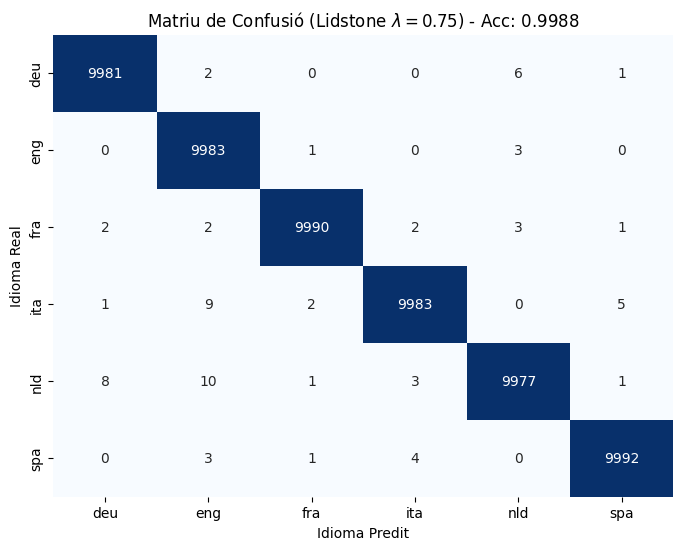


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9981     2     0     0     6     1
eng     0  9983     1     0     3     0
fra     2     2  9990     2     3     1
ita     1     9     2  9983     0     5
nld     8    10     1     3  9977     1
spa     0     3     1     4     0  9992


In [ ]:
def obtenir_frases_netes(fitxer):
    with open(fitxer, 'r', encoding='utf-8') as f:
        text = f.read()
    return [frase for frase in text.split("  ") if len(frase.strip()) > 0]


models_definitius, N_def = {}, {}
vocabulari_global_def = set()

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean.txt"
    with open(fitxer_train, 'r', encoding='utf-8') as f:
        text_complet = f.read()
    
    finder = TrigramCollocationFinder.from_words(text_complet)
    
    # Tots els trigrammes abans de filtrar (Càlcul B)
    for trigramma in finder.ngram_fd.keys():
        vocabulari_global_def.add(trigramma)
        
    # Apliquem filtre >= 5
    finder.apply_freq_filter(5)
    model = finder.ngram_fd
    
    models_definitius[idioma] = model
    N_def[idioma] = sum(model.values())

B_global_def = len(vocabulari_global_def)

# Funció de Lidstone
def probabilitat_lidstone(frase, idioma, lamb=0.75):
    text = "  " + frase + "  "
    
    # Generem la llista de tuples exactament igual que faria el finder de NLTK
    trigrammes = [tuple(text[i:i+3]) for i in range(len(text)-2)]
    
    model = models_definitius[idioma]
    N = N_def[idioma]
    denominador = N + (lamb * B_global_def)
    log_p = 0.0
    
    for trig in trigrammes:
        c = model.get(trig, 0)
        p = (c + lamb) / denominador
        log_p += math.log(p)
        
    return log_p

y_true = []
y_pred = []

for idioma_real in idiomes:
    fitxer_test = f"{idioma_real}_tst_clean.txt"
    frases_test = obtenir_frases_netes(fitxer_test)
    
    for frase in frases_test:
        y_true.append(idioma_real)
        
        max_prob = -float('inf')
        idioma_predit = None
        
        for idioma_model in idiomes:
            prob = probabilitat_lidstone(frase, idioma_model, lmbda=0.75)
            if prob > max_prob:
                max_prob = prob
                idioma_predit = idioma_model
                
        y_pred.append(idioma_predit)

# Resultats 
acc_final = accuracy_score(y_true, y_pred)
print(f"\nResultat Final")
print(f"Accuracy en Test: {acc_final:.4f} ({int(acc_final * len(y_true))}/{len(y_true)} encerts)")

# Matriu de Confusió
cm = confusion_matrix(y_true, y_pred, labels=idiomes)
df_cm = pd.DataFrame(cm, index=idiomes, columns=idiomes)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriu de Confusió (Lidstone $\lambda=0.75$) - Acc: {acc_final:.4f}')
plt.ylabel('Idioma Real')
plt.xlabel('Idioma Predit')
plt.show()

print("\nMatriu de Confusió (Text):")
print(df_cm)

1. Construint els models definitius (100% Train) per a Interpolació...

2. Avaluant sobre el conjunt de Test (10.000 frases per idioma)...

=== RESULTAT FINAL ===
Accuracy en Test: 0.9989 (59914/59977 encerts)


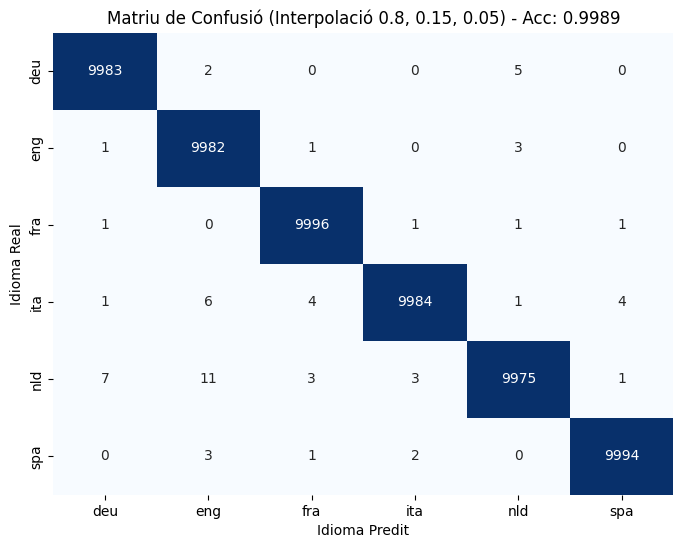


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9983     2     0     0     5     0
eng     1  9982     1     0     3     0
fra     1     0  9996     1     1     1
ita     1     6     4  9984     1     4
nld     7    11     3     3  9975     1
spa     0     3     1     2     0  9994


In [ ]:
def obtenir_frases_netes(fitxer):
    with open(fitxer, 'r', encoding='utf-8') as f:
        text = f.read()
    return [frase for frase in text.split("  ") if len(frase.strip()) > 0]


# Diccionaris per als models definitius i les seves N
models_uni_def, models_bi_def, models_tri_def = {}, {}, {}
N_uni_def, N_bi_def, N_tri_def = {}, {}, {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean.txt"
    with open(fitxer_train, 'r', encoding='utf-8') as f:
        text_complet = f.read()
    
    # Models d'Unigrames i Bigrames
    llista_chars = list(text_complet)
    models_uni_def[idioma] = nltk.FreqDist(llista_chars)
    models_bi_def[idioma] = nltk.FreqDist(nltk.ngrams(llista_chars, 2))
    
    N_uni_def[idioma] = len(llista_chars)
    N_bi_def[idioma] = len(llista_chars) - 1
    
    # Model principal de Trigrames
    finder = TrigramCollocationFinder.from_words(text_complet)

    # Apliquem filtre >= 5
    finder.apply_freq_filter(5)
    model3 = finder.ngram_fd
    
    models_tri_def[idioma] = model3
    N_tri_def[idioma] = sum(model3.values())


# Funció d'Interpolació (Guanyadora)
def probabilitat_interpolacio(frase, idioma, parametres=(0.8, 0.15, 0.05)):
    # Afegim els espais dobles com demana l'enunciat
    text = "  " + frase + "  "
    
    # Generem la llista de tuples 
    trigrammes = [tuple(text[i:i+3]) for i in range(len(text)-2)]
    
    lamb3, lamb2, lamb1 = parametres
    log_p = 0.0
    
    for trig in trigrammes:
        w_n_2, w_n_1, w_n = trig
        
        # P_3(w_n | w_n-2, w_n-1) = C(w_n-2, w_n-1, w_n) / C(w_n-2, w_n-1)
        c3 = models_tri_def[idioma].get(trig, 0)
        c2 = models_bi_def[idioma].get((w_n_2, w_n_1), 0)
        p3 = c3 / c2 if c2 > 0 else 0
        
        # P_2(w_n | w_n-1) = C(w_n-1, w_n) / C(w_n-1)
        c_bigrama = models_bi_def[idioma].get((w_n_1, w_n), 0)
        c1 = models_uni_def[idioma].get(w_n_1, 0)
        p2 = c_bigrama / c1 if c1 > 0 else 0
        
        # P_1(w_n) = C(w_n) / N_uni
        c_unigrama = models_uni_def[idioma].get(w_n, 0)
        p1 = c_unigrama / N_uni_def[idioma] if N_uni_def[idioma] > 0 else 0
        
        p = lamb1 * p1 + lamb2 * p2 + lamb3 * p3

        if p <= 0:
            p = 1e-10

        log_p += math.log(p)
        
    return log_p

y_true = []
y_pred = []

for idioma_real in idiomes:
    fitxer_test = f"{idioma_real}_tst_clean.txt"
    frases_test = obtenir_frases_netes(fitxer_test)
    
    for frase in frases_test:
        y_true.append(idioma_real)
        
        max_prob = -float('inf')
        idioma_predit = None
        
        for idioma_model in idiomes:
            # Utilitzem la funció amb els paràmetres guanyadors
            prob = probabilitat_interpolacio(frase, idioma_model, parametres=(0.8, 0.15, 0.05))
            if prob > max_prob:
                max_prob = prob
                idioma_predit = idioma_model
                
        y_pred.append(idioma_predit)

# Resultats
acc_final = accuracy_score(y_true, y_pred)
print(f"\nResultat Final")
print(f"Accuracy en Test: {acc_final:.4f} ({int(acc_final * len(y_true))}/{len(y_true)} encerts)")

# Matriu de Confusió
cm = confusion_matrix(y_true, y_pred, labels=idiomes)
df_cm = pd.DataFrame(cm, index=idiomes, columns=idiomes)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriu de Confusió (Interpolació 0.8, 0.15, 0.05) - Acc: {acc_final:.4f}')
plt.ylabel('Idioma Real')
plt.xlabel('Idioma Predit')
plt.show()

print("\nMatriu de Confusió (Text):")
print(df_cm)